1. Make sure that b-splines are correct
    x. Check the code for obvious errors
    2. Write energy function that works with b-splines
    3. Check if the TPF and B-spline energies are the same
2. Write LinReg optimization function
3. Fit energy to an existing potential (e.g., Marinica)
4. Write Backfitting optimization function
5. Optimize stat. distance

In [99]:
%matplotlib inline
import os
import sys
import re
import copy
import numpy as np
import pickle
from scipy.optimize import fmin
import multiprocessing as mp
import functools
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# statmech library setup
sys.path.append('../../statmechlib')
from statmechlib.preprocessing import select_nodes, to_param_dict, to_param_list, tpf_to_bsplines
from statmechlib.preprocessing import Trajectory, scale_configuration, pair_dist_cutoff, find_index
from statmechlib.preprocessing import universal_eos, downselect
from statmechlib.read_write import params_to_pickle
from statmechlib.forcefields import u_core

In [4]:
working = '../data/working'

In [5]:
stats_file = 'stats_bs_samples' # 'stats_samples'

In [6]:
with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_tpf = pickle.load(fi)

In [7]:
print(stats_tpf['hyperparams'])

{u'pair': [1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45, 4.55, 4.65, 4.75, 4.8500000000000005, 4.95, 5.05, 5.15, 5.25, 5.35, 5.45, 5.55, 5.65, 5.75, 5.8500000000000005, 5.95], u'edens': [1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45, 4.55, 4.65, 4.75, 4.8500000000000005, 4.95, 5.05, 5.15, 5.25, 5.35, 5.45, 5.55, 5.65, 5.75, 5.8500000000000005, 5.95]}


In [8]:
np.linspace(1.05, 5.95, 50)

array([1.05, 1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85, 1.95, 2.05,
       2.15, 2.25, 2.35, 2.45, 2.55, 2.65, 2.75, 2.85, 2.95, 3.05, 3.15,
       3.25, 3.35, 3.45, 3.55, 3.65, 3.75, 3.85, 3.95, 4.05, 4.15, 4.25,
       4.35, 4.45, 4.55, 4.65, 4.75, 4.85, 4.95, 5.05, 5.15, 5.25, 5.35,
       5.45, 5.55, 5.65, 5.75, 5.85, 5.95])

In [9]:
stats_tpf.keys()

[u'function',
 'bcc_npt_langevin_3700K',
 'vac_npt_langevin_2000K',
 'inf',
 'relax',
 'screw_111_npt_langevin_2000K',
 u'hyperparams',
 'bcc_npt_langevin_300K',
 'eos_bcc',
 'eos',
 'fcc_npt_langevin_300K',
 'vacint',
 'eos_fcc',
 'i110_npt_langevin_2000K',
 'liq_3700K',
 'liq_5000K',
 'i111_npt_langevin_2000K',
 'bain']

In [10]:
stats_bspline = tpf_to_bsplines(stats_tpf)

len 50


(2.0, 5.86)

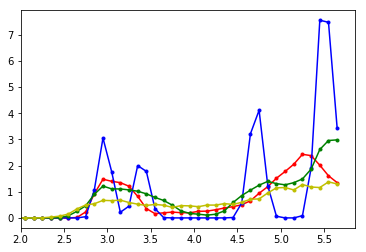

In [11]:
plt.plot(np.array(stats_bspline['hyperparams']['pair'][:-3])+0.4, stats_bspline['fcc_npt_langevin_300K']['energy'][0][2][:-3], 'r.-')
plt.plot(np.array(stats_bspline['hyperparams']['pair'][:-3])+0.4, stats_bspline['bcc_npt_langevin_300K']['energy'][0][2][:-3], 'b.-')
plt.plot(np.array(stats_bspline['hyperparams']['pair'][:-3])+0.4, stats_bspline['bcc_npt_langevin_3700K']['energy'][0][2][:-3], 'g.-')
plt.plot(np.array(stats_bspline['hyperparams']['pair'][:-3])+0.4, stats_bspline['liq_5000K']['energy'][0][2][:-3], 'y.-')
#plt.plot(np.array(stats_bspline['hyperparams']['pair'][:-4-3]), stats_bspline['eos']['energy'][2][2][:-3], 'c.-')
plt.xlim(2.0)


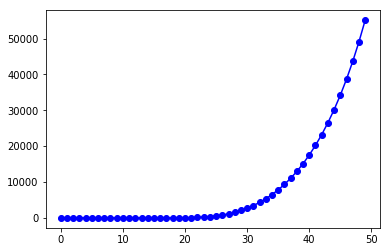

In [12]:
plt.plot(stats_tpf['relax']['energy'][0][2], 'bo-')

In [13]:
target_file = 'target_bs_samples'
with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targets = pickle.load(fi)

In [14]:
targets['eos']['box'] = targets['eos']['box'][4:9]
targets['eos']['xyz'] = targets['eos']['xyz'][4:9]
targets['eos']['temp'] = targets['eos']['temp'][4:9]
targets['eos']['beta'] = targets['eos']['beta'][4:9]
targets['eos']['energy'] = targets['eos']['energy'][4:9]
stats_bspline['eos']['energy'] = stats_bspline['eos']['energy'][4:9]

In [15]:
targets['relax']['box'][1] = targets['inf']['box'][0]
targets['relax']['xyz'][1] = targets['inf']['xyz'][0]
targets['relax']['temp'][1] = targets['inf']['temp'][0]
targets['relax']['beta'][1] = targets['inf']['beta'][0]
targets['relax']['energy'][1] = targets['inf']['energy'][0]
stats_bspline['relax']['energy'][1] = stats_bspline['inf']['energy'][0]

In [16]:
targets['eos_fcc']['weight'] = 0.0
targets['bain']['weight'] = 0.0
targets['eos']['weight'] = 0.0
targets['eos_bcc']['weight'] = 0.0
targets['relax']['weight'] = 1.0
targets['inf']['weight'] = 0.0
targets['vacint']['weight'] = 0.0
targets['fcc_npt_langevin_300K']['weight'] = 1.0
# targets['screw_111_npt_langevin_2000K']['weight'] = 0.0
# targets['vac_npt_langevin_2000K']['weight'] = 0.0
# targets['i111_npt_langevin_2000K']['weight'] = 0.0
# targets['i110_npt_langevin_2000K']['weight'] = 0.0



#targets['liq_5000K']['weight'] = 0.1
[(key, targets[key]['weight']) for key in targets.keys()]

[('bcc_npt_langevin_3700K', 1.0),
 ('eos', 0.0),
 ('vac_npt_langevin_2000K', 1.0),
 ('inf', 0.0),
 ('relax', 1.0),
 ('screw_111_npt_langevin_2000K', 1.0),
 ('bcc_npt_langevin_300K', 1.0),
 ('eos_bcc', 0.0),
 ('liq_5000K', 1.0),
 ('fcc_npt_langevin_300K', 1.0),
 ('vacint', 0.0),
 ('eos_fcc', 0.0),
 ('i110_npt_langevin_2000K', 1.0),
 ('liq_3700K', 1.0),
 ('i111_npt_langevin_2000K', 1.0),
 ('bain', 0.0)]

In [17]:
pair_knots = [2.5648975, 2.629795, 2.6946925, 2.8663175, 2.973045,
              3.0797725, 3.5164725, 3.846445, 4.1764175, 4.700845,
              4.8953, 5.089755, 5.3429525,5.401695,5.4604375]

pair_knots = list(np.linspace(2.05, 5.25, 33))

#mb_knots = list(np.linspace(3.95, 5.25, 14))
mb_knots = list(np.linspace(3.75, 5.25, 16))

print(mb_knots)
print(pair_knots)
print(len(pair_knots))

[3.75, 3.85, 3.95, 4.05, 4.15, 4.25, 4.35, 4.45, 4.55, 4.65, 4.75, 4.85, 4.95, 5.05, 5.15, 5.25]
[2.05, 2.15, 2.25, 2.3499999999999996, 2.4499999999999997, 2.55, 2.65, 2.75, 2.8499999999999996, 2.9499999999999997, 3.05, 3.15, 3.25, 3.3499999999999996, 3.45, 3.55, 3.65, 3.75, 3.8499999999999996, 3.95, 4.05, 4.15, 4.25, 4.35, 4.45, 4.55, 4.65, 4.75, 4.85, 4.95, 5.05, 5.15, 5.25]
33


In [18]:
# Select knots for optimization
# cycle over knots of selected models

stats_list = []
for knot in mb_knots:
    edens_knots = [knot]
    #print(len(pair_knots), len(edens_knots), len(stats_bspline['hyperparams']['pair']))
    stats = downselect(stats_bspline, pair_knots, edens_knots)
    #print(stats['hyperparams'])
#     stats_select_md = downselect(stats_md, pair_knots, edens_knots)
#     print(stats_select_md['hyperparams'])
#     stats['md'] = stats_select_md['md']
    stats_list.append(stats)

In [19]:
def make_matrices(target, stats, weights=False):
    """
    Creates input data for energy minimization with target as dependent variable and stats as independent.
    Assumes that all appropriate knots from stats have been selected, so it includes everything.
    """
    
    # matrix of independent variables (Embedding and B-spline coefficients)
    X = []
    # vector of dependent variable (configurational energies)
    y = []
    
    for key in target:
        
        # eliminate trajectories with 0 weight
        if weights:
            if target[key]['weight'] == 0.0:
                continue

        for i, (config, energy) in enumerate(zip(stats[key]['energy'], target[key]['energy'])):
            # add energy
            y.append(energy)
            
            # create an array of independent variables
            x_vars = [config[0][0], config[1][0]] # embedding
            #print('x_vars', x_vars, key, i, stats[key]['energy'][0][0], stats[key]['energy'][1][0])
            #print('x_vars', x_vars, stats[key]['energy'][0][0], stats[key]['energy'][1][0])

            #print('config[2]', config[2])
            x_vars += list(config[2])                   # pair interaction b-spline stats
            X.append(x_vars)
    
    return np.array(X), np.array(y)

In [20]:
binom = [1.0, -4.0, 6.0, -4.0, 1.0]

def make_bspline(coeffs, k, r):
    """
    Calculate energy from a cubic b-spline-based potential
    """
    
    u = 0.0
    for i, c in enumerate(coeffs):        
        for j, b in enumerate(binom):
            # truncated polynomial basis function
            tpf = (k[i+j]-r)**3 if r < k[i+j] else 0.0
            
            # contribution to potential from a b-spline basis function component
            u += c*b*tpf
            #u += c*b*tpf(r, k[i+j])
        
    return u

In [22]:
print(pair_knots)

 [2.05, 2.15, 2.25, 2.3499999999999996, 2.4499999999999997, 2.55, 2.65, 2.75, 2.8499999999999996, 2.9499999999999997, 3.05, 3.15, 3.25, 3.3499999999999996, 3.45, 3.55, 3.65, 3.75, 3.8499999999999996, 3.95, 4.05, 4.15, 4.25, 4.35, 4.45, 4.55, 4.65, 4.75, 4.85, 4.95, 5.05, 5.15, 5.25]


(2.0, 5.65)

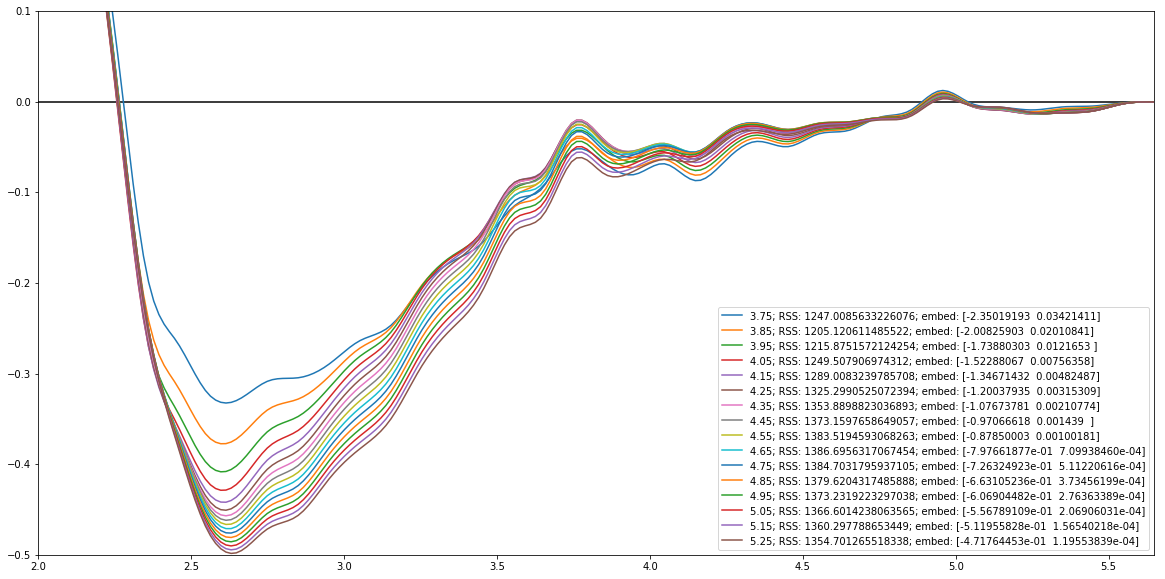

In [176]:
plt.figure(figsize=(20,10))
betas = []
for i, stat in enumerate(stats_list[:]):
#     if i != 1:
#         continue
    X, y = make_matrices(targets, stat, weights=True)
    #print(X.shape, y.shape)
    b = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    rss = (y - X.dot(b)).T.dot(y - X.dot(b))
    label_str = str(round(stat['hyperparams']['edens'][0], 2))
    label_str += '; RSS: ' + str(rss)
    label_str += '; embed: ' + str(b[:2])
    #plt.plot(np.array(pair_knots)+0.2, b[2:], label=label_str)
    
    rr = np.linspace(1.5, 5.7, 250)
    coeffs = [2000, 500, 100., 50.] + list(b[2:])
    knots = [1.65, 1.75, 1.85, 1.95] + pair_knots +[5.35, 5.45, 5.55, 5.65]
    #bs = [180*make_bspline(b[2:], pair_knots+[5.35, 5.45, 5.55, 5.65], r) for r in rr]
    bs = [make_bspline(coeffs, knots, r) for r in rr]

    plt.plot(rr, bs, label=label_str)
    
    betas.append(b)


plt.hlines(0,1,6)
plt.legend(loc='lower right')
plt.ylim(-100,2000)
plt.ylim(-0.5,0.1)
plt.xlim(2.0,5.65)

In [177]:
betas[9]

array([-7.97661877e-01,  7.09938460e-04,  9.36869736e+00, -4.53153121e+01,
       -5.97827239e+01, -7.76831222e+01, -7.99601782e+01, -7.08869150e+01,
       -7.08368600e+01, -6.19524110e+01, -5.59983201e+01, -5.23194193e+01,
       -4.00601994e+01, -3.36947303e+01, -2.98108591e+01, -1.41806441e+01,
       -1.87424967e+01, -4.33734780e-01, -9.90277706e+00, -9.93639403e+00,
       -6.45645674e+00, -1.10581923e+01, -4.67749065e+00, -3.19238821e+00,
       -6.06148393e+00, -3.53538974e+00, -4.18999386e+00, -2.40577228e+00,
       -3.76806379e+00,  2.70977314e+00, -1.47551509e+00, -8.53464647e-01,
       -2.52731261e+00, -1.86569893e+00, -2.02055609e+00])

(2.0, 5.5)

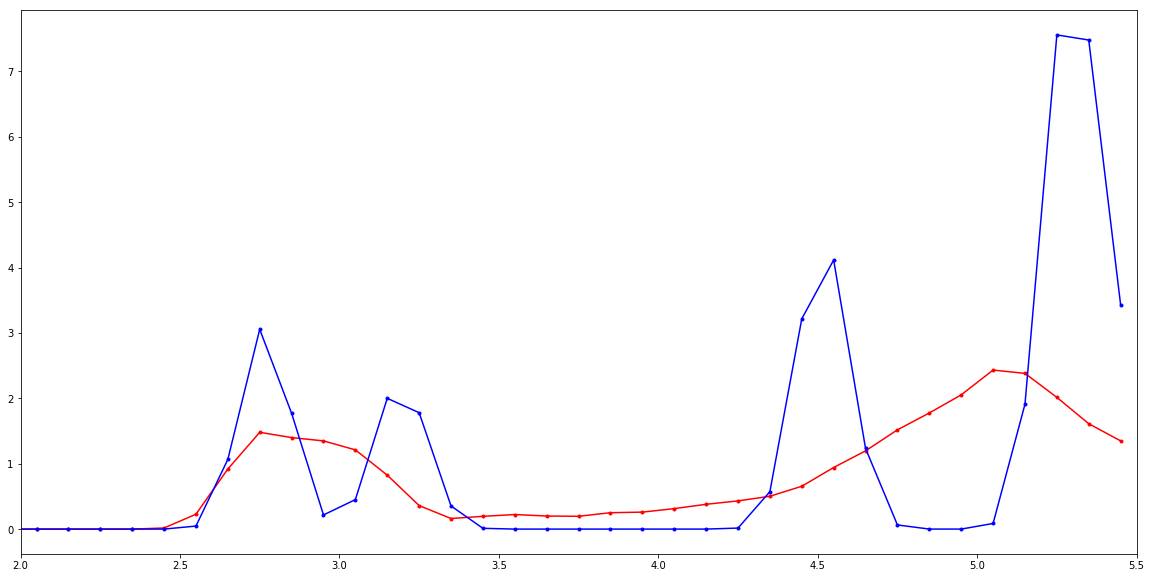

In [24]:
plt.figure(figsize=(20,10))
plt.plot(np.array(stats_bspline['hyperparams']['pair'][:-3])+0.2, stats_bspline['fcc_npt_langevin_300K']['energy'][0][2][:-3], 'r.-')
plt.plot(np.array(stats_bspline['hyperparams']['pair'][:-3])+0.2, stats_bspline['bcc_npt_langevin_300K']['energy'][0][2][:-3], 'b.-')
# plt.plot(np.array(stats_bspline['hyperparams']['pair'][:-3])+0.2, stats_bspline['bcc_npt_langevin_3700K']['energy'][0][2][:-3], 'g.-')
# plt.plot(np.array(stats_bspline['hyperparams']['pair'][:-3])+0.2, stats_bspline['liq_5000K']['energy'][0][2][:-3], 'y.-')
#plt.plot(np.array(stats_bspline['hyperparams']['pair'][:-4-3]), stats_bspline['eos']['energy'][2][2][:-3], 'c.-')
plt.xlim(2.0,5.5)


In [79]:
# Select knots for optimization
# cycle over knots of selected models
pair_knots = list(np.linspace(2.05, 5.25, 33))


stats_list = []
for knot in mb_knots:
    edens_knots = [knot]
    #print(len(pair_knots), len(edens_knots), len(stats_bspline['hyperparams']['pair']))
    stats = downselect(stats_bspline, pair_knots, edens_knots)
    #print(stats['hyperparams'])
#     stats_select_md = downselect(stats_md, pair_knots, edens_knots)
#     print(stats_select_md['hyperparams'])
#     stats['md'] = stats_select_md['md']
    stats_list.append(stats)

In [80]:
def penalty_matrix(n, order):
    
    pen ={2:[1.0, -2.0, 1.0],
          3:[1.0, -3.0, 3.0, -1.0]}
    
    D = np.zeros((n-2-order, n), dtype=float)
    
    for i in range(n-2-order):
        D[i, 2+i:2+i+1+order] = pen[order]

    return D

In [81]:
X, y = make_matrices(targets, stats_list[0], weights=True)


In [82]:
X.shape, len(stats_list[0])

((1395, 35), 18)

In [83]:
D = penalty_matrix(len(pair_knots)+2, 3)
Dsqr = D.T.dot(D)
print(Dsqr)

[[  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   1. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...  19. -12.   3.]
 [  0.   0.   0. ... -12.  10.  -3.]
 [  0.   0.   0. ...   3.  -3.   1.]]


(2.0, 5.65)

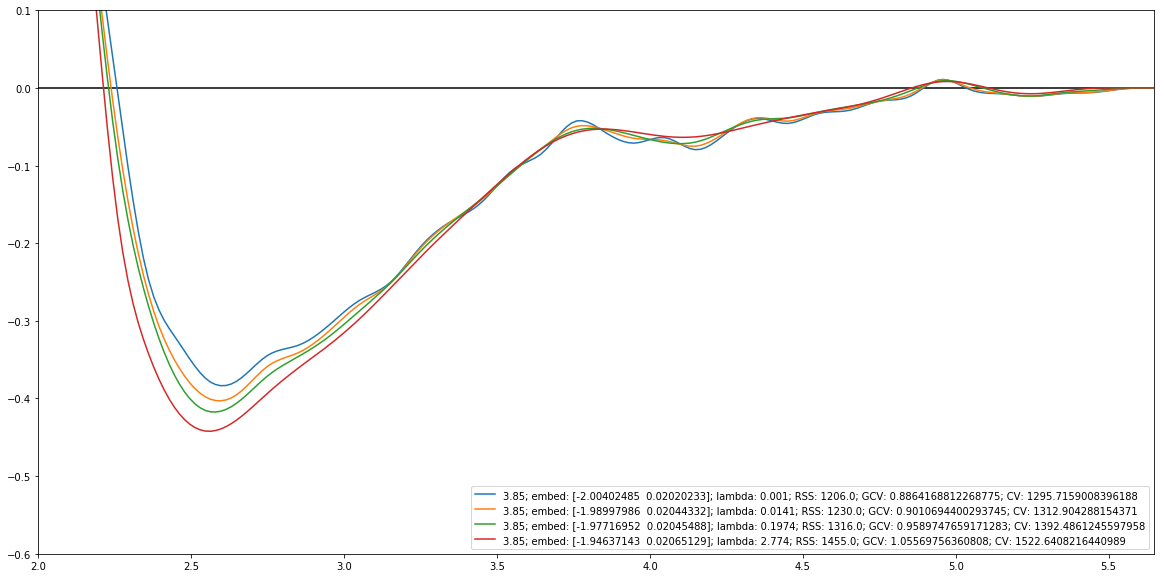

In [164]:
plt.figure(figsize=(20,10))
betas = []
for i, stat in enumerate(stats_list[1:2]):
#     if i != 1:
#         continue
    for lamb in list(np.logspace(-3, np.log10(2.774), 4)):
        X, y = make_matrices(targets, stat, weights=True)
    #print(X.shape, y.shape)
        b = np.linalg.inv(X.T.dot(X) + lamb*Dsqr).dot(X.T).dot(y)
        
        
        rss = (y - X.dot(b)).T.dot(y - X.dot(b))
        label_str = str(round(stat['hyperparams']['edens'][0], 2))
        label_str += '; embed: ' + str(b[:2])
        label_str += '; lambda: ' + str(round(lamb, 4))
        label_str += '; RSS: ' + str(round(rss, 0))
        
        hat = X.dot(np.linalg.inv(X.T.dot(X) + lamb*Dsqr)).dot(X.T)
        hat_trace = np.trace(hat)
        gcv = (y - X.dot(b)).T.dot(y - X.dot(b))/(X.shape[0] - hat_trace)
        label_str += '; GCV: ' + str(gcv)#str(round(gcv, 0))
        
        vec = (y - X.dot(b))/(1. - np.diag(hat))
        cv = vec.T.dot(vec)
        
        label_str += '; CV: ' + str(cv)#str(round(gcv, 0))


    #plt.plot(np.array(pair_knots)+0.2, b[2:], label=label_str)
    
        rr = np.linspace(1.5, 5.7, 250)
        coeffs = [2000, 500, 100., 50.] + list(b[2:])
        knots = [1.65, 1.75, 1.85, 1.95] + pair_knots +[5.35, 5.45, 5.55, 5.65]
#         coeffs = list(b[2:])
#         knots = pair_knots +[5.35, 5.45, 5.55, 5.65]
    #bs = [180*make_bspline(b[2:], pair_knots+[5.35, 5.45, 5.55, 5.65], r) for r in rr]
        bs = [make_bspline(coeffs, knots, r) for r in rr]

        plt.plot(rr, bs, label=label_str)
    
        betas.append(b)


plt.hlines(0,1,6)
plt.legend(loc='lower right')
plt.ylim(-100,2000)
plt.ylim(-0.6,0.1)
plt.xlim(2.0,5.65)

In [165]:
betas

[array([-2.00402485e+00,  2.02023325e-02,  3.48831664e+00, -4.53326164e+01,
        -5.32169929e+01, -6.44601326e+01, -6.42202336e+01, -5.60164649e+01,
        -5.60658090e+01, -5.11840307e+01, -4.48280899e+01, -4.31782903e+01,
        -3.32541285e+01, -2.82406002e+01, -2.56799285e+01, -1.61947727e+01,
        -1.55556693e+01, -4.68387929e+00, -9.62844112e+00, -1.31401652e+01,
        -8.93484747e+00, -1.53025876e+01, -9.49867466e+00, -5.19753807e+00,
        -8.99870536e+00, -4.63013692e+00, -5.60544063e+00, -2.07490458e+00,
        -3.21333231e+00,  3.81490736e+00, -1.40525675e+00, -1.01486494e+00,
        -2.24276110e+00, -9.77347002e-01, -1.23833056e+00]),
 array([-1.98997986e+00,  2.04433180e-02, -1.04132861e+01, -4.52166701e+01,
        -6.02110523e+01, -6.78603883e+01, -6.71064474e+01, -5.84167727e+01,
        -5.75483280e+01, -5.24548242e+01, -4.58348421e+01, -4.31068198e+01,
        -3.36803463e+01, -2.84026027e+01, -2.44702486e+01, -1.76903300e+01,
        -1.30302950e+01, -7

## Perform K-fold cross-validation based on leaving out different trajectories

* Get a list of trajectories
* For each cycle, leave one trajectory out
* Try different lambdas

In [28]:
trajs = targets.keys()
trajs.remove('eos')
trajs.remove('eos_bcc')
trajs.remove('eos_fcc')
trajs.remove('inf')
trajs.remove('bain')
trajs.remove('vacint')
len(trajs), trajs

(10,
 ['bcc_npt_langevin_3700K',
  'vac_npt_langevin_2000K',
  'relax',
  'screw_111_npt_langevin_2000K',
  'bcc_npt_langevin_300K',
  'liq_5000K',
  'fcc_npt_langevin_300K',
  'i110_npt_langevin_2000K',
  'liq_3700K',
  'i111_npt_langevin_2000K'])

In [29]:
# targets['eos_fcc']['weight'] = 0.0
# targets['bain']['weight'] = 0.0
# targets['eos']['weight'] = 0.0
# targets['eos_bcc']['weight'] = 0.0
# targets['relax']['weight'] = 0.0
# targets['inf']['weight'] = 0.0
# targets['vacint']['weight'] = 0.0
# targets['fcc_npt_langevin_300K']['weight'] = 0.0
# targets['screw_111_npt_langevin_2000K']['weight'] = 0.0
# targets['vac_npt_langevin_2000K']['weight'] = 0.0
# targets['i111_npt_langevin_2000K']['weight'] = 0.0
# targets['i110_npt_langevin_2000K']['weight'] = 0.0



#targets['liq_5000K']['weight'] = 0.1
[(key, targets[key]['weight']) for key in trajs]

[('bcc_npt_langevin_3700K', 1.0),
 ('vac_npt_langevin_2000K', 1.0),
 ('relax', 1.0),
 ('screw_111_npt_langevin_2000K', 1.0),
 ('bcc_npt_langevin_300K', 1.0),
 ('liq_5000K', 1.0),
 ('fcc_npt_langevin_300K', 1.0),
 ('i110_npt_langevin_2000K', 1.0),
 ('liq_3700K', 1.0),
 ('i111_npt_langevin_2000K', 1.0)]

In [33]:
def kfold_cv(stat, target, trajs, grid):
    """
    K-fold cross validation for a set of K trajectories.
    Leave-one-trajectory-out approach (rather than one sample out)
    """
    
    lamb_cv = []

    # cycle over hyperparameters
    for lamb in grid: 
        
        rss_list = []
        beta_list = []
        # select a trajectory to exclude from fitting
        for k in range(len(trajs)):
            
            # create target without k-th trajectory
            t = {key:val for key, val in target.items() if key != trajs[k]}
            
            # create statistics without k-th trajectory
            s = {key:val for key, val in stat.items() if key != trajs[k]}

            # build X and y for the K-1 set of trajectories
            X, y = make_matrices(t, s, weights=True)
            
            #print(X.shape, y.shape)
            b = np.linalg.inv(X.T.dot(X) + lamb*Dsqr).dot(X.T).dot(y)
            
            # least squares training error
            rss_train = (y - X.dot(b)).T.dot(y - X.dot(b))
            rss_train /= y.shape[0]
            
            # build X and y for the K-1 set of trajectories
            t = {key:val for key, val in target.items() if key == trajs[k]}
            s = {key:val for key, val in stat.items() if key == trajs[k]}
            X, y = make_matrices(t, s, weights=True)

            # least squares prediction error
            rss = (y - X.dot(b)).T.dot(y - X.dot(b))
            rss /= y.shape[0]
            rss_list.append(rss)
            #print(rss_train, rss, y.shape[0], trajs[k])

            beta_list.append(b)
            
        rss_list = np.array(rss_list)
        rss_ave = np.mean(rss_list)
        rss_min = np.min(rss_list)
        rss_max = np.max(rss_list)
        
        #print('average error:', round(lamb,3), round(rss_ave,2), round(rss_min,2), round(rss_max,2))

        lamb_cv.append((lamb, rss_ave, rss_min, rss_max))
        
    return np.array(lamb_cv)

In [34]:
grid = [0.0] + list(np.logspace(-3, 1, 80))

In [38]:
cv_scores = kfold_cv(stats, targets, trajs, grid)
lamb_best = sorted(cv_scores, key=lambda x: x[-1])[:10]
lamb_best

[array([ 2.77356261,  8.65243547,  0.78768547, 27.01521836]),
 array([ 2.46834047,  8.78302548,  0.79668093, 27.22214062]),
 array([ 3.11652694,  8.5193444 ,  0.75435658, 27.41022832]),
 array([ 3.50190046,  8.38484714,  0.70463052, 27.84451183]),
 array([ 3.93492726,  8.25035563,  0.65752954, 28.31973583]),
 array([ 4.42149991,  8.11762713,  0.61359319, 28.83729645]),
 array([ 2.19670709,  8.91030448,  0.80495149, 28.93824408]),
 array([ 4.96823959,  7.98878745,  0.57331253, 29.39826622]),
 array([ 5.58258627,  7.86634321,  0.53711136, 30.00334148]),
 array([ 1.95496614,  9.03371215,  0.81252515, 30.56759922])]

In [39]:
def best_params(stat, target, trajs, lamb):
    
    X, y = make_matrices(target, stat, weights=True)

    b = np.linalg.inv(X.T.dot(X) + lamb*Dsqr).dot(X.T).dot(y)
        
    #rss = (y - X.dot(b)).T.dot(y - X.dot(b))
    
    return b#, rss
    

## Minimizing statistical distance

1. Start from previously optimized parameters beta and lambda
2. Include additional b-splines basis functions 
3. Include additional constraints on beta at the short range
4. Set up Newton optimizer (as a function)

In [89]:
print(lamb_best[0][0])
b_old = best_params(stats, targets, trajs, lamb_best[0][0])
b_old

2.773562614198415


array([-4.68020455e-01,  1.19572562e-04, -1.07303573e+01, -4.75704775e+01,
       -7.21260451e+01, -8.47411694e+01, -8.69632646e+01, -8.29147079e+01,
       -7.78537409e+01, -7.24653553e+01, -6.61306192e+01, -5.87192390e+01,
       -5.05491765e+01, -4.21690454e+01, -3.35418557e+01, -2.51721329e+01,
       -1.82340428e+01, -1.35690389e+01, -1.12700845e+01, -1.04314266e+01,
       -9.80240225e+00, -8.61393220e+00, -6.93472762e+00, -5.53827608e+00,
       -4.65907291e+00, -4.04983752e+00, -3.76141683e+00, -2.90408135e+00,
       -1.05092501e+00,  6.89720535e-01,  6.56155815e-01, -6.39500506e-01,
       -1.72143471e+00, -1.79801786e+00, -7.96160573e-01])

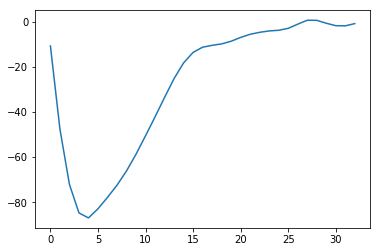

In [41]:
plt.plot(b_old[2:])

[17113.755717924174, 12406.19941786865, 9097.307487244881, 6739.652597343368, 5038.609752573664, 3797.215914698409]
[3031.1189265160906, 2265.021938333772, 1498.9249501514537, 732.8279619691352, -33.269026213183224]
[-3.32690262e+01 -5.68786602e+01 -7.06104327e+01 -7.49413738e+01
 -7.17416818e+01 -6.52981248e+01 -6.00156638e+01 -5.53771375e+01
 -4.97560022e+01 -4.31135832e+01 -3.61873896e+01 -2.98346025e+01
 -2.37176891e+01 -1.76732288e+01 -1.25284475e+01 -9.34605583e+00
 -8.56833079e+00 -9.46312268e+00 -1.05915624e+01 -1.07332696e+01
 -9.52477652e+00 -7.83879760e+00 -6.43659787e+00 -5.17888541e+00
 -4.19820309e+00 -2.52818719e+00 -1.44109258e-02  1.72713688e+00
  9.87660904e-01 -8.34504908e-01 -1.50943076e+00 -7.29751797e-01
  5.68539375e-02]


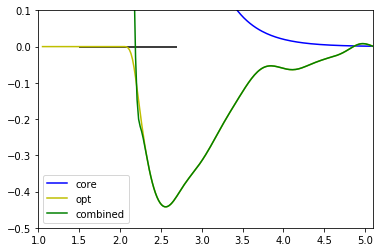

In [65]:
rr = np.linspace(1.05, 5.7, 250)

# core
plt.plot(rr, [u_core(r) for r in rr], 'b-', label='core')

#optimized
coeffs = list(b[2:])
knots = pair_knots + [5.35, 5.45, 5.55, 5.65]
bs = [make_bspline(coeffs, knots, r) for r in rr]
plt.plot(rr, bs, 'y-', label='opt')

#combined
#low_knots = list(np.linspace(1.05, 1.95, 10))
low_knots = list(np.linspace(1.05, 1.45, 6))
mid_knots = list(np.linspace(1.55, 1.95, 5))

coeffs_core = [u_core(r+0.2)/(6*0.1**3) for r in low_knots]
coeffs_low = coeffs_core 

# linear interpolation between core and beta values
coeffs_mid = [coeffs_core[-1] + (b[2] - coeffs_core[-1])*(i/5.) for i in range(1, 6)]

knots_all = low_knots + mid_knots + pair_knots + [5.35, 5.45, 5.55, 5.65]
coeffs_all = coeffs_low + coeffs_mid + list(b[2:])
bs_all = [make_bspline(coeffs_all, knots_all, r) for r in rr]
plt.plot(rr, bs_all, 'g-', label='combined')

plt.legend()
plt.hlines(0.0, 1.5, 2.7)
plt.ylim(-0.5, 0.1)
plt.xlim(1.0, 5.1)

#[(make_bspline(coeffs, knots, k), c, c/make_bspline(coeffs, knots, k+0.2)) for k, c in zip(pair_knots, coeffs)]
print(coeffs_low)
print(coeffs_mid)
print(b[2:])

In [58]:
print(coeffs)

[-33.26902621318301, -56.87866015650425, -70.61043270925958, -74.94137378700285, -71.74168177427484, -65.29812482214167, -60.01566375985087, -55.377137514835816, -49.75600223667735, -43.11358316312513, -36.187389620783065, -29.83460252674938, -23.717689091742535, -17.673228750166473, -12.528447476093831, -9.346055826923745, -8.568330793039763, -9.46312268256294, -10.591562421098978, -10.733269564876863, -9.52477652152206, -7.838797596636297, -6.436597874426468, -5.17888541476691, -4.1982030861854795, -2.5281871850693918, -0.014410925779245076, 1.7271368844812436, 0.9876609035597124, -0.8345049080225735, -1.5094307585045392, -0.7297517972624306, 0.056853937515889186]


In [87]:
len(knots_all), len(coeffs_all)

(48, 44)

In [ ]:
def get_weights(X, y, b):
    """
    Creates weight vectors needed for Newton-Raphson optimization
    in iterative reweighted least squares

    Parameters
    ----------
    X: ndarray(N, p)
        design matrix
    y: ndarray(N)
        target values
    b: ndarray(p)
        current parameters

    Returns
    -------
    P: ndarray(N)
        vector of weights exp[-0.5*(sum(X*b) - y)]
    P2: ndarray(N)
        vector of weights exp[-(sum(X.b) - y)]
    """    
    

In [114]:
def make_sd_matrices(target, stats, weights=False):
    """
    Creates input data for energy minimization with target as dependent variable and stats as independent.
    Assumes that all appropriate knots from stats have been selected, so it includes everything.
    """
    
    # matrix of independent variables (Embedding and B-spline coefficients)
    X = []
    # vector of dependent variable (configurational energies)
    y = []
    # bector of inverse temperatures
    beta = []
    
    for key in target:
        
        # eliminate trajectories with 0 weight
        if weights:
            if target[key]['weight'] == 0.0:
                continue

        for i, (config, energy, bb) in enumerate(zip(stats[key]['energy'], target[key]['energy'], target[key]['beta'])):
            # add energy
            y.append(energy)
            beta.append(bb)
            
            # create an array of independent variables
            x_vars = [config[0][0], config[1][0]] # embedding
            #print('x_vars', x_vars, key, i, stats[key]['energy'][0][0], stats[key]['energy'][1][0])
            #print('x_vars', x_vars, stats[key]['energy'][0][0], stats[key]['energy'][1][0])

            #print('config[2]', config[2])
            x_vars += list(config[2])                   # pair interaction b-spline stats
            X.append(x_vars)
    
    return np.array(X), np.array(y), np.array(beta)

In [201]:
def newton_raphson(X, y, beta, b_init, tol=1e-5, itmax=10000):
    
    b_old = copy.copy(b_init)
    
    itcount = 0
    while True:

        # weight vector and inverse weight matrix
        P = np.exp(-0.5*beta*(X.dot(b_old) - y))
        P2 = P**2
        W = X.T.dot(np.diag(0.5*P - P2)).dot(X)
        Wi = np.linalg.inv(W)
        
        b_new = b_old + Wi.dot(X.T).dot(P - P2)
        
        itcount += 1
        
        loss = np.arccos(1. - (1 - P).T.dot(1 - P)/(2.0*len(y)))**2
        
        if itcount % 100 == 0:
            print(itcount, loss, np.sum(abs(b_new - b_old)), beta[0], 1/beta[0])

        if (np.sum(abs(b_new - b_old)) < tol) or itcount > itmax:
            break

        b_old = b_new
    
    return b_new, loss

In [192]:
print(len(b_old), X.shape, y.shape)
b_init = b_old

b_init = np.array([-2.00402485e+00,  2.02023325e-02,  3.48831664e+00, -4.53326164e+01,
        -5.32169929e+01, -6.44601326e+01, -6.42202336e+01, -5.60164649e+01,
        -5.60658090e+01, -5.11840307e+01, -4.48280899e+01, -4.31782903e+01,
        -3.32541285e+01, -2.82406002e+01, -2.56799285e+01, -1.61947727e+01,
        -1.55556693e+01, -4.68387929e+00, -9.62844112e+00, -1.31401652e+01,
        -8.93484747e+00, -1.53025876e+01, -9.49867466e+00, -5.19753807e+00,
        -8.99870536e+00, -4.63013692e+00, -5.60544063e+00, -2.07490458e+00,
        -3.21333231e+00,  3.81490736e+00, -1.40525675e+00, -1.01486494e+00,
        -2.24276110e+00, -9.77347002e-01, -1.23833056e+00])
b_init = np.array([-7.97661877e-01,  7.09938460e-04,  9.36869736e+00, -4.53153121e+01,
       -5.97827239e+01, -7.76831222e+01, -7.99601782e+01, -7.08869150e+01,
       -7.08368600e+01, -6.19524110e+01, -5.59983201e+01, -5.23194193e+01,
       -4.00601994e+01, -3.36947303e+01, -2.98108591e+01, -1.41806441e+01,
       -1.87424967e+01, -4.33734780e-01, -9.90277706e+00, -9.93639403e+00,
       -6.45645674e+00, -1.10581923e+01, -4.67749065e+00, -3.19238821e+00,
       -6.06148393e+00, -3.53538974e+00, -4.18999386e+00, -2.40577228e+00,
       -3.76806379e+00,  2.70977314e+00, -1.47551509e+00, -8.53464647e-01,
       -2.52731261e+00, -1.86569893e+00, -2.02055609e+00])
b_init = np.array([-4.68020455e-01,  1.19572562e-04, -1.07303573e+01, -4.75704775e+01,
       -7.21260451e+01, -8.47411694e+01, -8.69632646e+01, -8.29147079e+01,
       -7.78537409e+01, -7.24653553e+01, -6.61306192e+01, -5.87192390e+01,
       -5.05491765e+01, -4.21690454e+01, -3.35418557e+01, -2.51721329e+01,
       -1.82340428e+01, -1.35690389e+01, -1.12700845e+01, -1.04314266e+01,
       -9.80240225e+00, -8.61393220e+00, -6.93472762e+00, -5.53827608e+00,
       -4.65907291e+00, -4.04983752e+00, -3.76141683e+00, -2.90408135e+00,
       -1.05092501e+00,  6.89720535e-01,  6.56155815e-01, -6.39500506e-01,
       -1.72143471e+00, -1.79801786e+00, -7.96160573e-01])

(35, (1395, 35), (1395,))


In [202]:
for i, stat in enumerate(stats_list[1:2]):

    X, y, beta = make_sd_matrices(targets, stat, weights=True)
    print(X.shape, y.shape, beta.shape, b_init.shape)

    b_final, loss_final = newton_raphson(X, y, beta, b_init, itmax=1e5)

((1395, 35), (1395,), (1395,), (35,))
(100, 0.0032371783071101163, 1.1630412522080806, 0.00030135095633725996, 3318.39)
(200, 0.0017783036916120968, 0.7046972152595818, 0.00030135095633725996, 3318.39)
(300, 0.0010817318114042702, 0.6001815864572144, 0.00030135095633725996, 3318.39)
(400, 0.0007293016661325553, 0.6375796670020734, 0.00030135095633725996, 3318.39)
(500, 0.0005402069570036377, 0.7094806333672918, 0.00030135095633725996, 3318.39)
(600, 0.00043146212892598477, 0.7406593730650931, 0.00030135095633725996, 3318.39)
(700, 0.00036354305277832666, 0.7465032780960812, 0.00030135095633725996, 3318.39)
(800, 0.00031713684526403756, 0.7387703148958737, 0.00030135095633725996, 3318.39)
(900, 0.0002826116697304043, 0.7250541629418374, 0.00030135095633725996, 3318.39)
(1000, 0.00025506805280864494, 0.7032429000557266, 0.00030135095633725996, 3318.39)
(1100, 0.0002319549903336203, 0.6760464671687849, 0.00030135095633725996, 3318.39)
(1200, 0.00021190173678121657, 0.6456254631086413, 0.0

(9900, 1.1208393549915539e-06, 0.12991783837223814, 0.00030135095633725996, 3318.39)
(10000, 1.0718232657295229e-06, 0.12888879402953232, 0.00030135095633725996, 3318.39)
(10100, 1.0251758778411984e-06, 0.12783325643959376, 0.00030135095633725996, 3318.39)
(10200, 9.8077554367055e-07, 0.12675320029911008, 0.00030135095633725996, 3318.39)
(10300, 9.385073839324724e-07, 0.12565051484647044, 0.00030135095633725996, 3318.39)
(10400, 8.982628702681954e-07, 0.12452700707284359, 0.00030135095633725996, 3318.39)
(10500, 8.599394391090602e-07, 0.12338440485900433, 0.00030135095633725996, 3318.39)
(10600, 8.234401288550475e-07, 0.12222436000778766, 0.00030135095633725996, 3318.39)
(10700, 7.886732441428087e-07, 0.12104845105128359, 0.00030135095633725996, 3318.39)
(10800, 7.555520409859444e-07, 0.11985818622333914, 0.00030135095633725996, 3318.39)
(10900, 7.23994433897747e-07, 0.11865500601670292, 0.00030135095633725996, 3318.39)
(11000, 6.939227218877782e-07, 0.1174402857477131, 0.0003013509563

(19600, 7.233923570469515e-08, 0.03245783603229302, 0.00030135095633725996, 3318.39)
(19700, 7.170370295951913e-08, 0.031894229262419915, 0.00030135095633725996, 3318.39)
(19800, 7.109349706643746e-08, 0.031339360469623136, 0.00030135095633725996, 3318.39)
(19900, 7.050755065701391e-08, 0.03079312895883964, 0.00030135095633725996, 3318.39)
(20000, 6.994484321422533e-08, 0.030255433884158085, 0.00030135095633725996, 3318.39)
(20100, 6.940439840792598e-08, 0.0297261743183931, 0.00030135095633725996, 3318.39)
(20200, 6.888528254053543e-08, 0.02920524931253086, 0.00030135095633725996, 3318.39)
(20300, 6.838660277068156e-08, 0.028692557968043965, 0.00030135095633725996, 3318.39)
(20400, 6.790750467070987e-08, 0.028187999481884243, 0.00030135095633725996, 3318.39)
(20500, 6.744717111646035e-08, 0.02769147320137913, 0.00030135095633725996, 3318.39)
(20600, 6.700482006682138e-08, 0.027202878688895704, 0.00030135095633725996, 3318.39)
(20700, 6.657970389759597e-08, 0.026722115752101337, 0.00030

(29200, 5.582728727519907e-08, 0.005430384144825131, 0.00030135095633725996, 3318.39)
(29300, 5.5804585434580344e-08, 0.0053259937416505615, 0.00030135095633725996, 3318.39)
(29400, 5.578251175815488e-08, 0.005223551335339128, 0.00030135095633725996, 3318.39)
(29500, 5.5761045595774226e-08, 0.005123022273124864, 0.00030135095633725996, 3318.39)
(29600, 5.5740168073646764e-08, 0.005024372467867737, 0.00030135095633725996, 3318.39)
(29700, 5.57198603179809e-08, 0.004927568386854812, 0.00030135095633725996, 3318.39)
(29800, 5.5700104565208075e-08, 0.004832577052606431, 0.00030135095633725996, 3318.39)
(29900, 5.568088327380433e-08, 0.004739366028198459, 0.00030135095633725996, 3318.39)
(30000, 5.566217979042414e-08, 0.004647903411572514, 0.00030135095633725996, 3318.39)
(30100, 5.5643978127855797e-08, 0.004558157829536991, 0.00030135095633725996, 3318.39)
(30200, 5.5626262520932186e-08, 0.004470098428809872, 0.00030135095633725996, 3318.39)
(30300, 5.560901809266466e-08, 0.004383694869255

(38700, 5.5008064133858025e-08, 0.0008261499287588077, 0.00030135095633725996, 3318.39)
(38800, 5.5005730667083474e-08, 0.0008096742027878072, 0.00030135095633725996, 3318.39)
(38900, 5.5003446938300876e-08, 0.000793522953613908, 0.00030135095633725996, 3318.39)
(39000, 5.500121161524261e-08, 0.00077768990290316, 0.00030135095633725996, 3318.39)
(39100, 5.4999023809730224e-08, 0.0007621688908168549, 0.00030135095633725996, 3318.39)
(39200, 5.4996882189496095e-08, 0.0007469538737325913, 0.00030135095633725996, 3318.39)
(39300, 5.499478586636178e-08, 0.000732038921931865, 0.00030135095633725996, 3318.39)
(39400, 5.499273395214887e-08, 0.000717418217832163, 0.00030135095633725996, 3318.39)
(39500, 5.4990725114589695e-08, 0.0007030860538294534, 0.00030135095633725996, 3318.39)
(39600, 5.4988758909595065e-08, 0.0006890368306848027, 0.00030135095633725996, 3318.39)
(39700, 5.4986834004897334e-08, 0.000675265054634451, 0.00030135095633725996, 3318.39)
(39800, 5.4984949734362675e-08, 0.0006617

(48100, 5.491166591023747e-08, 0.00012209890425613976, 0.00030135095633725996, 3318.39)
(48200, 5.491133906057603e-08, 0.00011962120107903221, 0.00030135095633725996, 3318.39)
(48300, 5.49110190942974e-08, 0.00011719345777714066, 0.00030135095633725996, 3318.39)
(48400, 5.4910705345267765e-08, 0.00011481467532749659, 0.00030135095633725996, 3318.39)
(48500, 5.4910398257576354e-08, 0.00011248387468712831, 0.00030135095633725996, 3318.39)
(48600, 5.491009738713393e-08, 0.00011020009606565323, 0.00030135095633725996, 3318.39)
(48700, 5.490980273394049e-08, 0.0001079623986868887, 0.00030135095633725996, 3318.39)
(48800, 5.490951407595144e-08, 0.0001057698603765464, 0.00030135095633725996, 3318.39)
(48900, 5.490923119112219e-08, 0.000103621577190946, 0.00030135095633725996, 3318.39)
(49000, 5.4908954301497305e-08, 0.00010151666308294907, 0.00030135095633725996, 3318.39)
(49100, 5.490868296298761e-08, 9.945424959766427e-05, 0.00030135095633725996, 3318.39)
(49200, 5.490841717559308e-08, 9.74

(57500, 5.4897986186092075e-08, 1.759790454989793e-05, 0.00030135095633725996, 3318.39)
(57600, 5.4897939334680006e-08, 1.7237438922526604e-05, 0.00030135095633725996, 3318.39)
(57700, 5.489789359349097e-08, 1.6884330904961414e-05, 0.00030135095633725996, 3318.39)
(57800, 5.489784896252496e-08, 1.6538431022526667e-05, 0.00030135095633725996, 3318.39)
(57900, 5.4897804997692795e-08, 1.6199592767864035e-05, 0.00030135095633725996, 3318.39)
(58000, 5.4897761921039036e-08, 1.5867672599922944e-05, 0.00030135095633725996, 3318.39)
(58100, 5.489771995460833e-08, 1.5542529982925934e-05, 0.00030135095633725996, 3318.39)
(58200, 5.4897678654311435e-08, 1.5224027047872069e-05, 0.00030135095633725996, 3318.39)
(58300, 5.489763824219297e-08, 1.491202888218024e-05, 0.00030135095633725996, 3318.39)
(58400, 5.489759871825293e-08, 1.4606403176097016e-05, 0.00030135095633725996, 3318.39)
(58500, 5.489756008249132e-08, 1.4307020337819831e-05, 0.00030135095633725996, 3318.39)
(58600, 5.489752211286353e-08

In [195]:
b_f3 = b_final

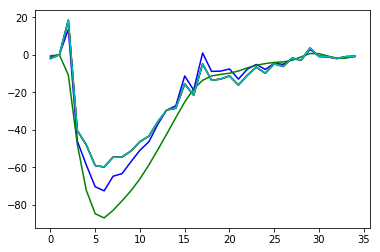

In [204]:
b1_opt = [-1.19779621e+00,  3.01214295e-03,  1.36637456e+01, -4.59144614e+01,
       -5.86185402e+01, -7.03333241e+01, -7.25130793e+01, -6.47367518e+01,
       -6.33318070e+01, -5.69755663e+01, -5.08589981e+01, -4.63387622e+01,
       -3.69662793e+01, -2.94232187e+01, -2.72120723e+01, -1.12698842e+01,
       -1.87832446e+01,  1.00113865e+00, -8.81946696e+00, -8.68285997e+00,
       -7.51891152e+00, -1.29463527e+01, -7.62027787e+00, -5.09924601e+00,
       -7.76796788e+00, -4.55852365e+00, -5.05730405e+00, -2.06635284e+00,
       -2.80157596e+00,  2.84145556e+00, -6.62974435e-01, -1.13167956e+00,
       -2.02476634e+00, -1.15996951e+00, -9.75193902e-01]

plt.plot(b1_opt, 'b')
plt.plot(b_f1, 'r')
plt.plot(b_init, 'g')
plt.plot(b_f2, 'y')
plt.plot(b_f3, 'k')
plt.plot(b_final, 'c')

In [200]:
[(b1-b2, b1-b3, b2-b3) for b1, b2, b3 in zip(b_f1, b_f2, b_f3)]

[(-1.1054492657258663e-05, -1.102355419213552e-05, 3.093846512314258e-08),
 (2.5160256329759267e-08, 2.500985789646859e-08, -1.5039843329067715e-10),
 (-0.0012938449213137915, -0.0013284975234881813, -3.465260217438981e-05),
 (-0.0002673045699737031, -0.00025546045792879113, 1.184411204491198e-05),
 (-2.644126803375002e-05, -2.892789500208437e-05, -2.486626968334349e-06),
 (1.6640363014630566e-05, 1.6127114072617132e-05, -5.132489420134334e-07),
 (1.0294052707138235e-05, 9.340545375380316e-06, -9.53507331757919e-07),
 (6.442526088079603e-05, 6.35388190275421e-05, -8.864418532539275e-07),
 (0.00014140317404809366, 0.00014019904445206066, -1.204129596032999e-06),
 (0.00018578401819269175, 0.00018511943478216608, -6.645834105256654e-07),
 (0.00025898351460540425, 0.00025767300824242056, -1.3105063629836877e-06),
 (0.000279544538194898, 0.00027848560701926317, -1.0589311756348252e-06),
 (0.000294891251911622, 0.0002937659614516974, -1.1252904599245994e-06),
 (0.00032957747087891676, 0.0003